# Load packages

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import shap 
import numpy as np
from statistics import mean
from matplotlib import pyplot
from sklearn.model_selection import train_test_split,cross_validate,GridSearchCV,RepeatedStratifiedKFold
from sklearn.metrics import ConfusionMatrixDisplay,accuracy_score,confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from collections import Counter
from imblearn.over_sampling import SMOTE,ADASYN

# Data Preparation

In [10]:
data = pd.read_csv('GreenvsControl.csv')
drop_col = ['SubID']
data = data.drop(columns=drop_col)
y = data['Group']
X = data.drop(columns=['Group','GroupLabel'])

Class=1, n=45 (17.647%)
Class=0, n=210 (82.353%)


<BarContainer object of 2 artists>

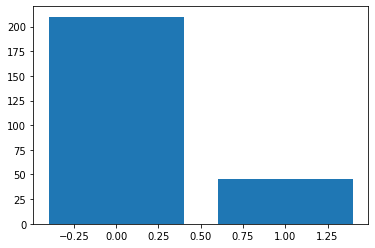

In [11]:
# summarize distribution
counter = Counter(y)
for k,v in counter.items():
    per = v / len(y) * 100
    print('Class=%s, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
plt.bar(counter.keys(), counter.values())


Perform oversampling with SMOTE

In [12]:
oversample = SMOTE()
over_X, over_y = oversample.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=10, stratify=y)
over_X_train, over_X_test, over_y_train, over_y_test = train_test_split(over_X, over_y, random_state=10, test_size=0.1, stratify=over_y)

Class=1, n=210 (82.353%)
Class=0, n=210 (82.353%)


<BarContainer object of 2 artists>

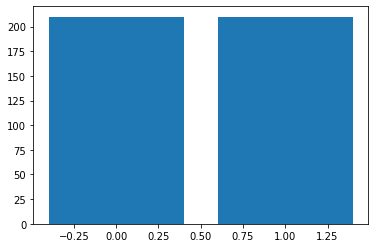

In [13]:
# summarize distribution with oversampled data
counter = Counter(over_y)
for k,v in counter.items():
    per = v / len(y) * 100
    print('Class=%s, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
plt.bar(counter.keys(), counter.values())


# Training process with original dataset

Define searching space

In [14]:
param_grid = { 
    'n_estimators': [200, 500, 1000],
    'max_features': ['sqrt', 'log2'],
    'max_depth' : [10,15,20],
    'criterion' :['gini', 'entropy','log_loss']
}

Define models and cross validation method

In [15]:
#Create random forest classifier model
SRF = RandomForestClassifier(random_state = 10)
#Create Stratified K-fold cross validation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=2, random_state=10)

Perform grid search for optimal hyperparameters with original dataset

In [16]:
CV_rfc = GridSearchCV(estimator=SRF, param_grid=param_grid, cv= cv, scoring= "accuracy")
CV_rfc.fit(X_train, y_train)

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=2, n_splits=10, random_state=10),
             estimator=RandomForestClassifier(random_state=10),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [10, 15, 20],
                         'max_features': ['sqrt', 'log2'],
                         'n_estimators': [200, 500, 1000]},
             scoring='accuracy')

Get the optimal hyperparameters

In [17]:
best_params = CV_rfc.best_params_
print(best_params)

{'criterion': 'entropy', 'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 200}


Evaluate the optimal model

In [18]:
# Get the estimator
best_rfc = CV_rfc.best_estimator_
# Find the scores for crossvalidation
scores = cross_validate(best_rfc, X, y, scoring='accuracy', cv=cv)
# Evaluate model
print('Mean accuracy with original dataset: %.3f' % mean(scores['test_score']))

Mean accuracy with original dataset: 0.996


# Training process with enhanced dataset

Perform grid search for optimal hyperparameters with enhanced dataset

In [19]:
over_CV_rfc = GridSearchCV(estimator=SRF, param_grid=param_grid, cv= cv, scoring= "accuracy" )
over_CV_rfc.fit(over_X, over_y)

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=2, n_splits=10, random_state=10),
             estimator=RandomForestClassifier(random_state=10),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [10, 15, 20],
                         'max_features': ['sqrt', 'log2'],
                         'n_estimators': [200, 500, 1000]},
             scoring='accuracy')

Get the optimal hyperparameters

In [20]:
over_best_params = over_CV_rfc.best_params_
print(over_best_params)

{'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 200}


Evaluate the optimal model

In [21]:
# Get the estimator
over_best_rfc = over_CV_rfc.best_estimator_
# Find the scores for crossvalidation
scores = cross_validate(over_best_rfc, over_X, over_y, scoring='accuracy', cv=cv)
# Evaluate model
print('Mean accuracy with SMOTE: %.3f' % mean(scores['test_score']))

Mean accuracy with SMOTE: 1.000


Confusion matrix with optimal model

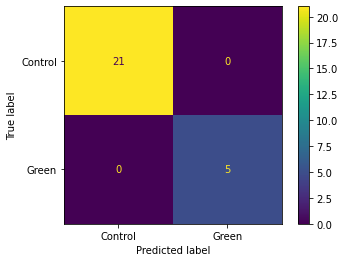

In [25]:
label = ['Control','Green']
cnf_matrix0 = confusion_matrix(y_test,over_best_rfc.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix0, display_labels=label)
disp.plot().figure_.savefig('Plot\Confusionmatrix_GreenvsControl.pdf',format="pdf", bbox_inches="tight")

# Save models

In [26]:
# Save model with original dataset
filename = 'RFC_Green_original.sav'
pickle.dump(best_rfc, open(filename, 'wb'))
# Save model with enhanced dataset
over_filename = 'RFC_Green_enhanced.sav'
pickle.dump(over_best_rfc, open(over_filename, 'wb'))

# SHAP analysis

Load model

In [27]:
# Load model
over_filename = 'RFC_Green_enhanced.sav'
RFC_Green = pickle.load(open(over_filename, 'rb'))

Extract SHAP values and shap interaction values

In [28]:
# Extract TreeExplainer
explainer = shap.TreeExplainer(RFC_Green)
# Get SHAP values
shap_values = explainer(X)
shap_values = explainer.shap_values(X)
# Get SHAP interaction values
shap_interaction_values = np.array(explainer.shap_interaction_values(X))
# Get the main effect values
main_effect = np.diagonal(shap_interaction_values[1], axis1=1, axis2=2)

Plot global importance

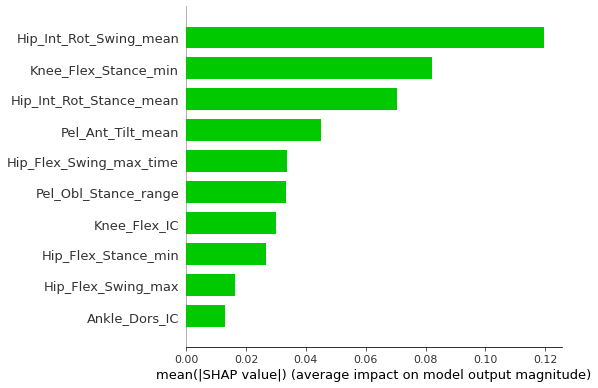

In [29]:
shap.summary_plot(shap_values[1],X,plot_type= 'bar',show=False, max_display = 10, color = '#00c900')
plt.savefig('Plot\SHAP_Global_GreenvsControl.pdf',format="pdf", bbox_inches="tight")

Plot local summary

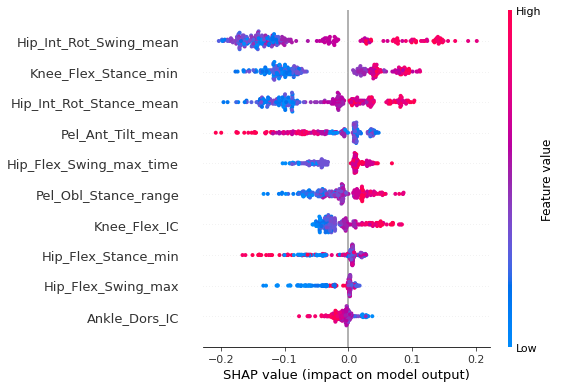

In [30]:
shap.summary_plot(shap_values[1],X,show=False, max_display = 10)
plt.savefig('Plot\SHAP_BeeSwarm_GreenvsControl.pdf',format="pdf", bbox_inches="tight")

Dependence plots

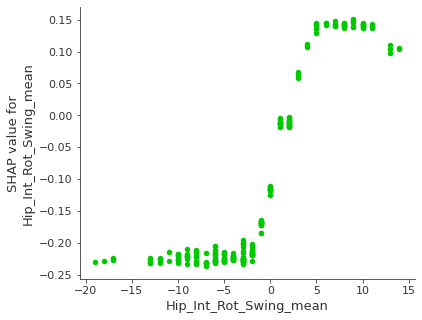

In [31]:
shap.dependence_plot("rank(0)", main_effect, X, interaction_index=None, show=False, color = '#00c900',dot_size=30)
plt.savefig('Plot\SHAP_dependence_rank0_GreenvsControl.pdf',format="pdf", bbox_inches="tight")

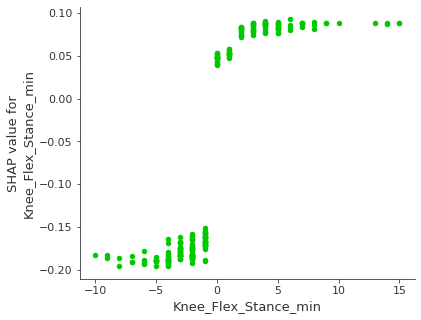

In [32]:
shap.dependence_plot("rank(1)", main_effect, X, interaction_index=None,show=False,  color = '#00c900',dot_size=30)
plt.savefig('Plot\SHAP_dependence_rank1_GreenvsControl.pdf',format="pdf", bbox_inches="tight")

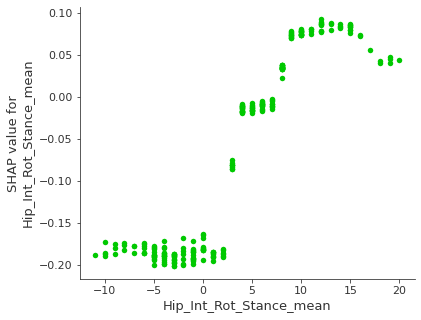

In [33]:
shap.dependence_plot("rank(2)", main_effect, X, interaction_index=None, show=False, color = '#00c900',dot_size=30)
plt.savefig('Plot\SHAP_dependence_rank2_GreenvsControl.pdf',format="pdf", bbox_inches="tight")